# Example of using the orm classes

Imports

In [1]:
from core.core import Project
from core.orm import BoreholeOrm, Base
from striplog import Lexicon, Striplog, Interval, Component, Position
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import omfvista as ov
import pyvista as pv
import omf

In [3]:
! rm ./tmp/test_orm_db.db

Define the project class

In [110]:
class Borehole3D(Striplog):
    #-------------------------------Docstring--------------------------------------------
    """
        
    """
    
    #------------------------------ Properties -------------------------------------------
    def __init__ (self, intervals=None, name=''):
        self.name = name

                  
        if intervals is None:
            lexicon=Lexicon.default()
            with open('../data/test.las', 'r') as las3:
                default_intv=Striplog.from_las3(las3.read(), lexicon)
                intervals = list(default_intv)
            print("Pay attention that default intervals are actually used !\n")
        self.intervals = intervals
        self.geometry = []
        
        # instanciation with supers properties
        Striplog.__init__(self, list_of_Intervals=self.intervals)
        
        #self.uid=uuid #get a unique for identification of borehole in the project

        self.build_geometry()
        
        
    def build_geometry(self, bh_itv=None):
        colors = ['#FF0000', '#00FF00', '#0000FF'] #FIXME: colors should be generated from a legend
        if bh_itv is None:
            bh_itv=self.intervals
            
        x, y = 0.5, 0.5 # we must use Borehole x,y coordinates here !!!
        vertices, segments = [], []

        for i in bh_itv:
            if i.top not in vertices:
                vertices.append([x, y, i.top.z])
            if i.base not in vertices:
                vertices.append([x, y, i.base.z])

        vertices=np.array(vertices)

        for l in np.arange(1,len(vertices)):
            #segments.append([l-1,l]) # here it is only one segment for an interval for now
            lin = omf.LineSetElement(name=f'Interval_{l}',
                                     geometry=omf.LineSetGeometry(
                                         vertices=np.array([vertices[l-1], vertices[l]]),
                                         segments=[[0,1]]),
                                     data=[omf.ScalarData(name='value',array=np.array([l]),location='segments')],
                                     color='#0000FF'
                                    )
            self.geometry.append(lin)
            
        print("Borehole geometry created successfully !")
        
        return self.geometry
        
    def plot3d(self):
        pl = pv.Plotter()
        for i in self.geometry:
            seg = ov.line_set_to_vtk(i)
            seg.set_active_scalars('value')
            ov.lineset.add_data(seg, i.data)
            pl.add_mesh(seg)
        pl.show()

In [111]:
bh3d = Borehole3D()

Pay attention that default intervals are actually used !

Borehole geometry created successfully !


In [112]:
project = ov.load_project('omfproj.omf')

In [113]:
type(project['Random Line'])

pyvista.core.pointset.PolyData

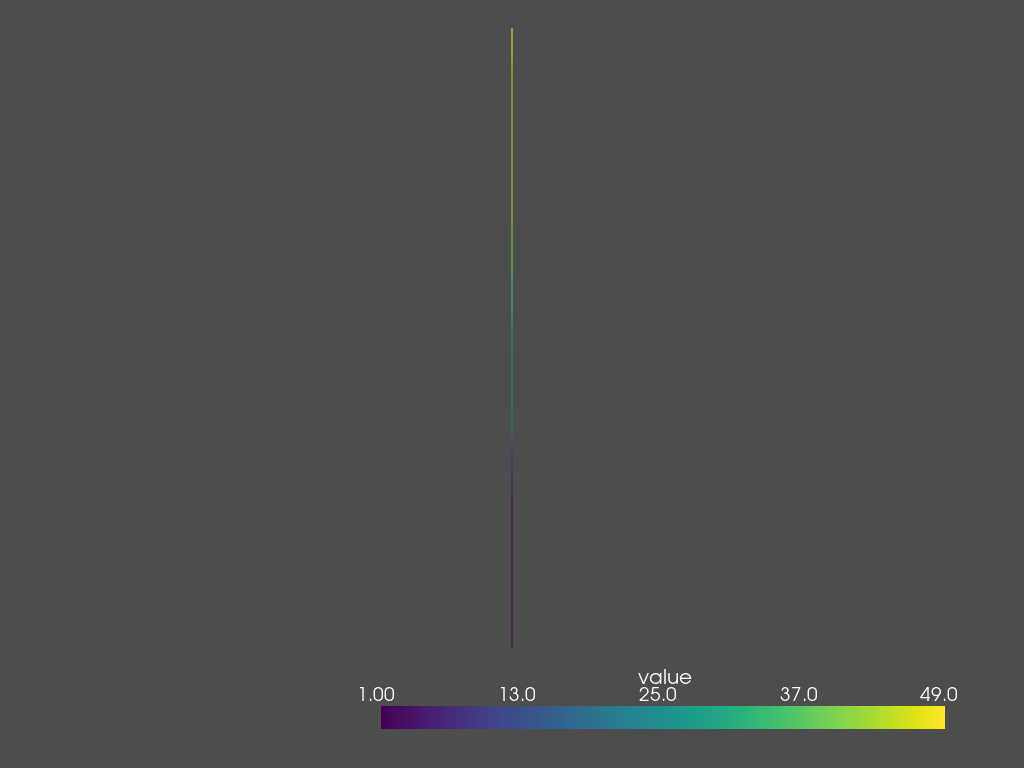

In [117]:
bh3d.plot3d()

Create the db engine and the database structure

In [7]:
engine = create_engine('sqlite:///tmp/test_orm_db.db', echo=True)

In [8]:
Base.metadata.create_all(engine)

2020-12-11 18:53:35,948 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-11 18:53:35,949 INFO sqlalchemy.engine.base.Engine ()
2020-12-11 18:53:35,951 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-11 18:53:35,952 INFO sqlalchemy.engine.base.Engine ()
2020-12-11 18:53:35,953 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2020-12-11 18:53:35,954 INFO sqlalchemy.engine.base.Engine ()
2020-12-11 18:53:35,956 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2020-12-11 18:53:35,957 INFO sqlalchemy.engine.base.Engine ()
2020-12-11 18:53:35,958 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Intervals")
2020-12-11 18:53:35,958 INFO sqlalchemy.engine.base.Engine ()
2020-12-11 18:53:35,959 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Intervals")
2020-12-11 18:53:35,960 INFO sqlalchemy.engine.base.Engine ()
2020-12-11

Create the objects from las files

In [9]:
lexicon = Lexicon.default()

In [10]:
borehole_dict = {'F01':'../data/test.las', 'F02':'../data/test.las'} # boreholes to insert into the db

In [11]:
int_id = 0
bh_id = 0
boreholes = []
components = []
comp_id = 0
component_dict={}
for bh, filename in borehole_dict.items():
    interval_number = 0
    boreholes.append(BoreholeOrm(id=bh))
    with open(filename, 'r') as las3:
        strip = Striplog.from_las3(las3.read(), lexicon)
    for c in strip.components:
        if c not in component_dict.keys():
            component_dict.update({c:comp_id})
            comp_id += 1
    d ={}
    for interval in strip:
        d.update({int_id:{'description':interval.description, 'interval_number' : interval_number}})
        interval_number+=1
        int_id += 1
    boreholes[bh_id].intervals_values = d
    bh_id += 1 
components = {v:k for k,v in component_dict.items()}     

Create the session

In [12]:
Session = sessionmaker(bind=engine)
session = Session()

Create the project

In [13]:
p = Project(session)

2020-12-11 18:53:36,054 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-11 18:53:36,062 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-11 18:53:36,064 INFO sqlalchemy.engine.base.Engine ()


Add boreholes into the database

In [14]:
for bh in boreholes:
    p.add_borehole(bh)

2020-12-11 18:53:36,074 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id) VALUES (?)
2020-12-11 18:53:36,075 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-11 18:53:36,078 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description) VALUES (?, ?, ?, ?)
2020-12-11 18:53:36,079 INFO sqlalchemy.engine.base.Engine ((0, 'F01', 0, 'Anhydrite'), (1, 'F01', 1, 'Sandstone, grey, vf-f'), (2, 'F01', 2, 'Anhydrite'), (3, 'F01', 3, 'Dolomite'), (4, 'F01', 4, 'Anhydrite'), (5, 'F01', 5, 'Sandstone, grey, vf-f'), (6, 'F01', 6, 'Siltstone, red'), (7, 'F01', 7, 'Dolomite')  ... displaying 10 of 25 total bound parameter sets ...  (23, 'F01', 23, 'Limestone'), (24, 'F01', 24, 'Volcanic'))
2020-12-11 18:53:36,081 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-11 18:53:36,085 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-11 18:53:36,093 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"


In [15]:
p.boreholes[0].id

'F01'

In [16]:
p.boreholes[1].id='F33'

In [17]:
p.boreholes[1].id

'F33'

In [18]:
p.commit()

2020-12-11 18:53:36,147 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET id=? WHERE "Boreholes".id = ?
2020-12-11 18:53:36,148 INFO sqlalchemy.engine.base.Engine ('F33', 'F02')
2020-12-11 18:53:36,150 INFO sqlalchemy.engine.base.Engine COMMIT


In [19]:
p.boreholes[0].intervals[0].description

2020-12-11 18:53:36,164 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-11 18:53:36,166 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2020-12-11 18:53:36,167 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-11 18:53:36,175 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2020-12-11 18:53:36,182 INFO sqlalchemy.engine.base.Engine ('F01',)


'Anhydrite'

In [ ]:
session.close()

In [ ]:
bh3d.intervals[0].base.z

In [ ]:
itvls = list(p.boreholes[0].intervals.values())

In [ ]:
z=0.
dz=10.
itvls_list = []
for itvl in itvls:
    comp = Component(lexicon.get_component(itvl.description))
    top = Position(x=0., y=10., middle=z)
    z += dz
    base = Position(x=0., y=10., middle=z)
    itvls_list.append(Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon))

In [ ]:
bh3d.intervals[0]

In [ ]:
itv = Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon)

In [ ]:
itv

In [ ]:
bh3d_2 = Borehole3D(itvls_list)

In [ ]:
bh3d_2.plot3d()